In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cftime
import pandas as pd

In [2]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [3]:
#To compute de climatoloy
yearC1='2004'
yearC2='2014'

# Read data

In [4]:
data_dir='/Users/pvb/Dropbox/Oceanografia/Data/Climatologias/EN.4.2.2.g10/NC/'

files = []
for iy in range(1950,2024):
    for im in range(1,13):
        files.append(data_dir+"EN.4.2.2.f.analysis.g10.%04d%02d.nc"%(iy,im))

In [6]:
data = xr.open_mfdataset(files)

In [7]:
EN = data.drop_vars("temperature_uncertainty").drop_vars("salinity_uncertainty")
EN = EN.drop_vars("temperature_observation_weights").drop_vars("salinity_observation_weights")

In [8]:
DC=EN

## Data selection

In [9]:
DC_temp=-273+EN.temperature.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))
DC_salt=EN.salinity.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [10]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_temp_anom.load();

DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim
DC_salt_anom.load();

/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]
/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


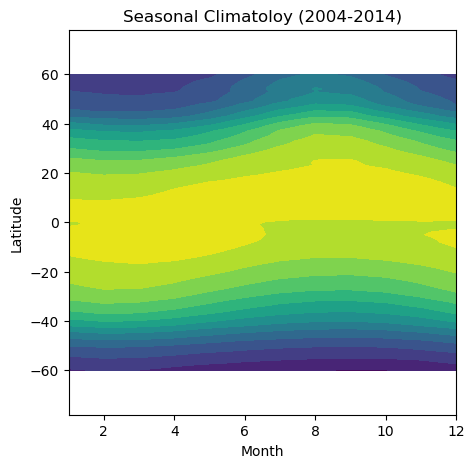

In [11]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").month,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").lat,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Mean weighted

In [12]:
weights = np.cos(np.deg2rad(EN.temperature.lat))
weights = weights/weights.max()
weights.name = "weights"
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)


DC_temp_wmean = DC_temp_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_wmean = DC_salt_weighted.mean(("lon", "lat"),skipna=True).load()

DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("lon", "lat"),skipna=True).load()

## Smoothed versions

In [13]:
DC_temp_wmean_rolling = DC_temp_wmean.rolling(time=12,center=True).mean()
DC_salt_wmean_rolling = DC_salt_wmean.rolling(time=12,center=True).mean()

DC_temp_anom_wmean_rolling = DC_temp_anom_wmean.rolling(time=12,center=True).mean()
DC_salt_anom_wmean_rolling = DC_salt_anom_wmean.rolling(time=12,center=True).mean()

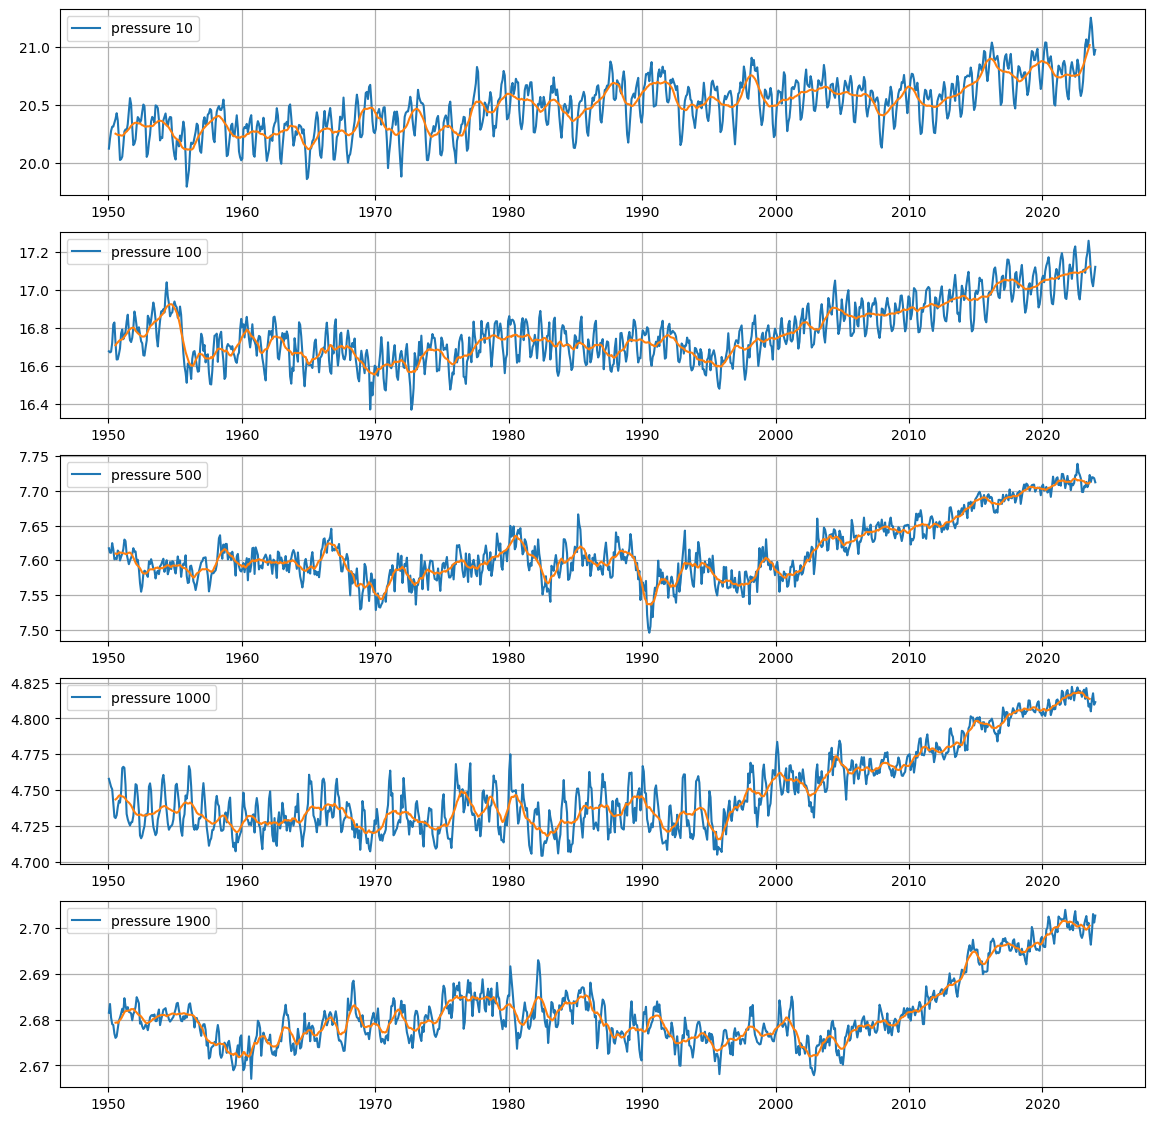

In [14]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(EN.time,DC_temp_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(EN.time,DC_temp_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1


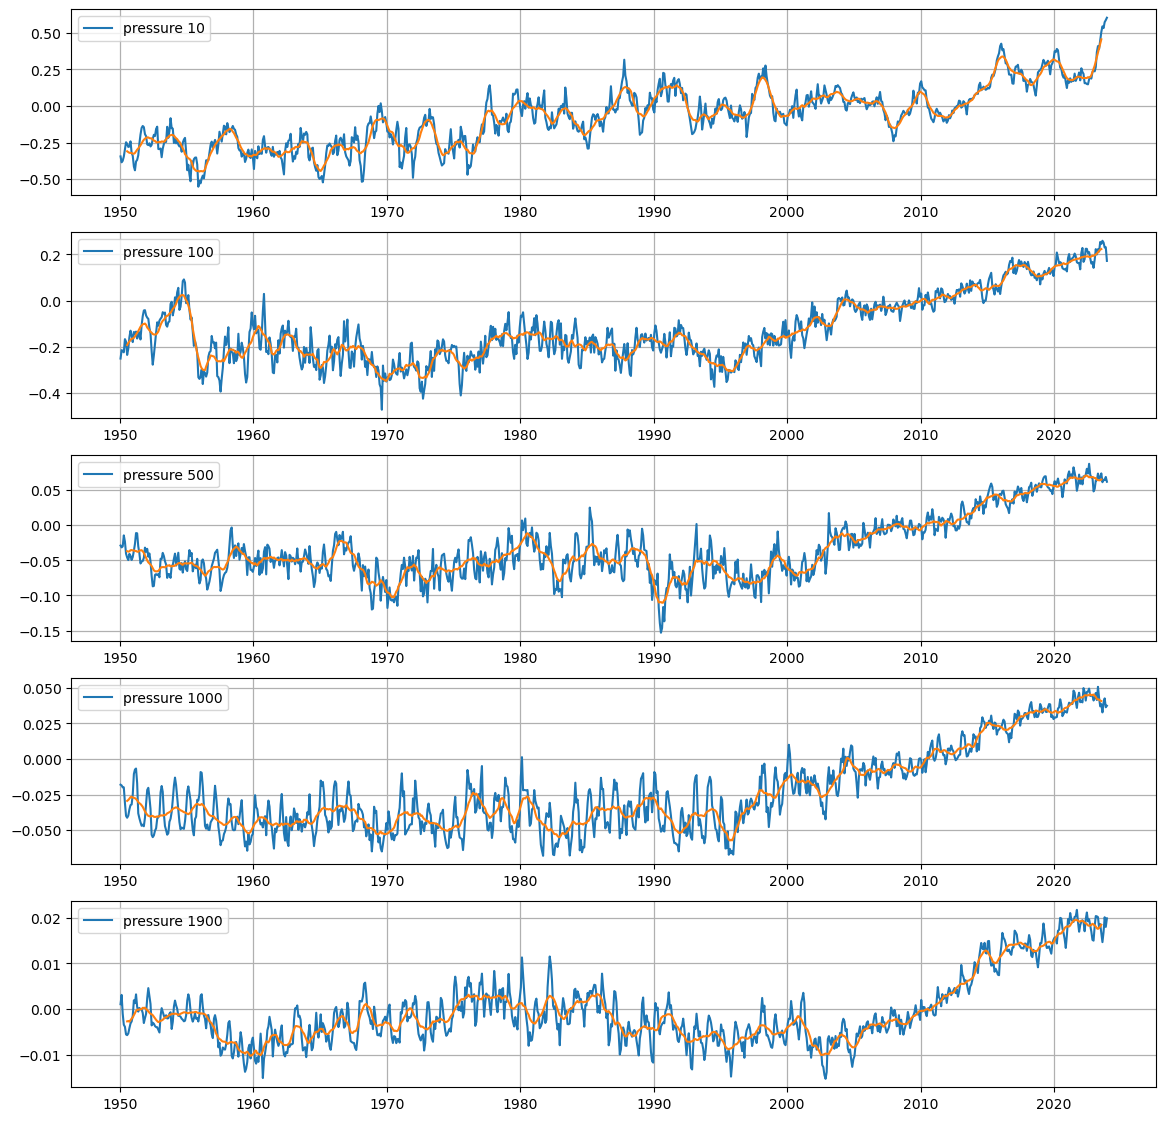

In [15]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(EN.time,DC_temp_anom_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(EN.time,DC_temp_anom_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1

## Global mean

In [17]:
DC_temp_global_2000m=DC_temp_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_global_2000m.to_netcdf('./Data/EN422g10_temp_global_2000m.nc')

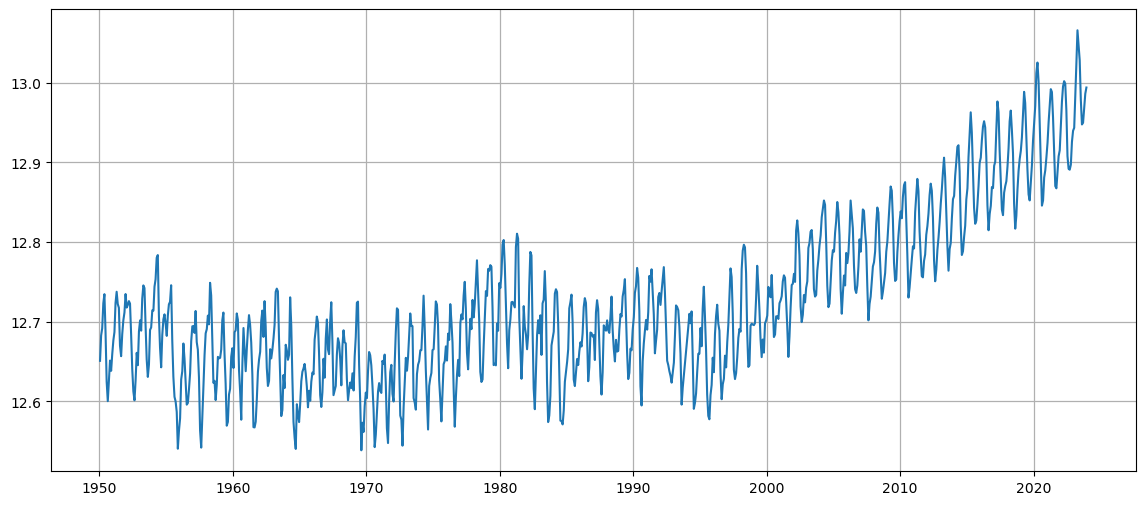

In [18]:
ig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC_temp_global_2000m.time,DC_temp_global_2000m,)
ax.grid(linestyle='-', linewidth=.9)

In [19]:
DC_temp_anom_global_2000m=DC_temp_anom_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_anom_global_2000m.to_netcdf('./Data/EN422g10_temp_anom_global_2000m.nc')

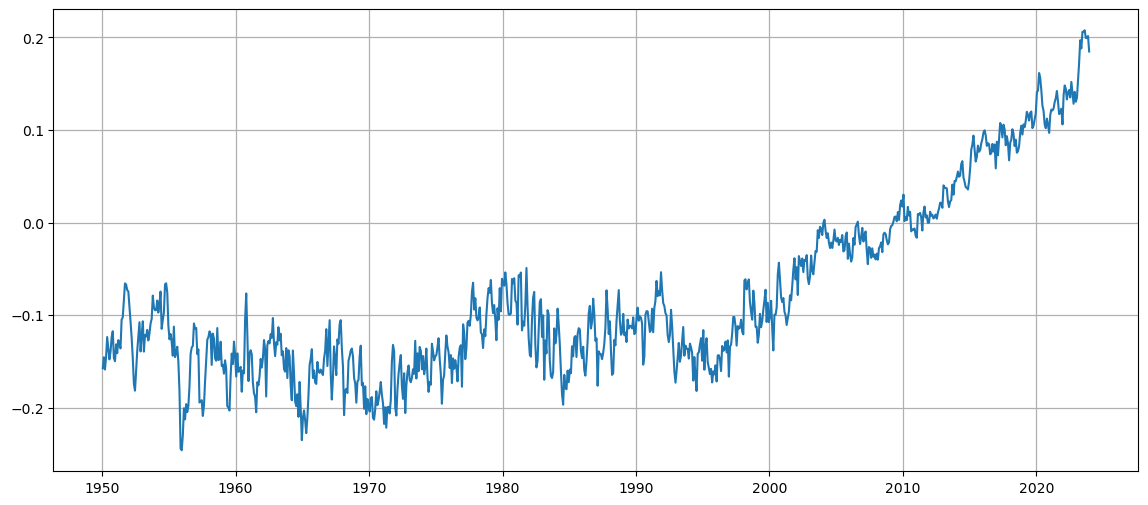

In [20]:
ig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC.time,DC_temp_anom_global_2000m)
ax.grid(linestyle='-', linewidth=.9)